# Plot UMAP of SBF2 scrambled PML bodies and SP100 and PML intensities
For figure 6, the different types of PML bodies detected

In [1]:
from campa.constants import EXPERIMENT_DIR
from campa.data import MPPData
from campa.tl import Experiment
from campa.tl import Cluster
from campa.tl._cluster import add_clustering_to_adata
from campa.pl import annotate_img
from campa.utils import init_logging
import os
import numpy as np
import scanpy as sc
import seaborn as sns
from campa.tl._cluster import annotate_clustering
import anndata as ad
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
init_logging()

In [2]:
exp_name = 'VAE_SBF2/CondVAE_siRNA-CC'
cluster_data_dir = os.path.join(exp_name, 'aggregated/sub-0.005_sub-0.33')
cluster_name = 'clustering_res0.9_sub-0.33_seed1'
cluster_col = 'annotation'

# load cluster object
cl = Cluster.from_cluster_data_dir(cluster_data_dir)
cl.set_cluster_name(cluster_name)


INFO:MPPData:Created new: MPPData for NascentRNA (442685 mpps with shape (3, 3, 43) from 2731 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:MPPData:Loaded data from VAE_SBF2/CondVAE_siRNA-CC/aggregated/sub-0.005_sub-0.33.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (442685 mpps with shape (3, 3, 43) from 2731 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'umap'].
INFO:Cluster:cannot create annotation without clustering in cluster_mpp
INFO:MPPData:Created new: MPPData for NascentRNA (442685 mpps with shape (3, 3, 43) from 2731 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.9_sub-0.33_seed1', 'umap'].
INFO:MPPData:Loaded data from VAE_SBF2/CondVAE_siRNA-CC/aggregated/sub-0.005_sub-0.33.
INFO:Cluster:Loaded cluster_mpp MPPData for NascentRNA (442685 mpps with shape (3, 3, 43) from 2731 objects). Data keys: ['x', 'y', 'obj_ids', 'mpp', 'latent', 'clustering_res0.9_sub-0.33_seed1', 'umap'].


In [3]:
# prepare mpp_datas from scrambled wells
data_params = json.load(open(os.path.join(cl.data_config.DATASET_DIR, cl.config['process_like_dataset'], 'params.json'), 'r'))

mpp_datas = []
for data_dir in cl.config['data_dirs']:
    if 'scrambled' not in data_dir:
        continue
    mpp_data = MPPData.from_data_dir(base_dir=os.path.join(EXPERIMENT_DIR, exp_name), data_dir=os.path.join('aggregated', 'full_data', data_dir),
         keys=['x', 'y', 'mpp', 'obj_ids', cluster_name])
    mpp_data.prepare(data_params)
    # convert clustering to str for export to adata
    mpp_data._data[cluster_name] = mpp_data.data(cluster_name).astype('str')
    mpp_datas.append(mpp_data)

INFO:MPPData:Created new: MPPData for NascentRNA (87151907 mpps with shape (1, 1, 44) from 1093 objects). Data keys: ['x', 'y', 'obj_ids', 'labels', 'mpp'].
INFO:MPPData:Loaded data from HeLa_scrambled/K19.
INFO:MPPData:Setting mpp to empty array
INFO:MPPData:Created new: MPPData for NascentRNA (58774977 mpps with shape (1, 1, 43) from 767 objects). Data keys: ['x', 'obj_ids', 'y', 'clustering_res0.9_sub-0.33_seed1', 'latent', 'mpp'].
INFO:MPPData:Before subsetting: 1093 objects
INFO:MPPData:Subsetting to 767 objects
INFO:MPPData:Updated data to keys ['x', 'y', 'obj_ids', 'labels', 'mpp', 'clustering_res0.9_sub-0.33_seed1', 'latent']
INFO:MPPData:Loaded data from aggregated/full_data/HeLa_scrambled/K19, with base data from HeLa_scrambled/K19
INFO:MPPData:Restricted channels to 43 channels
INFO:MPPData:Subtracting channel-specific background value defined in column mean_background
INFO:MPPData:Rescaling MPP intensities per channels with predefined values
INFO:MPPData:Adding conditions: 

In [26]:
# get cluster ids labelleds as PML bodies
cluster_ids = list(cl.cluster_annotation[cl.cluster_annotation['annotation'] == 'PML bodies']['clustering_res0.9_sub-0.33_seed1'])

# subset mpp_data to only PML bodies
sub_mpp_datas = []
for mpp_data in mpp_datas:
    mask = np.in1d(mpp_data._data['clustering_res0.9_sub-0.33_seed1'], cluster_ids)
    sub_mpp_data = mpp_data.apply_mask(mask, copy=True)
    sub_mpp_datas.append(sub_mpp_data)

INFO:MPPData:Created new: MPPData for NascentRNA (346150 mpps with shape (1, 1, 43) from 767 objects). Data keys: ['x', 'y', 'obj_ids', 'labels', 'mpp', 'clustering_res0.9_sub-0.33_seed1', 'latent', 'conditions'].
INFO:MPPData:Created new: MPPData for NascentRNA (375529 mpps with shape (1, 1, 43) from 809 objects). Data keys: ['x', 'y', 'obj_ids', 'labels', 'mpp', 'clustering_res0.9_sub-0.33_seed1', 'latent', 'conditions'].
INFO:MPPData:Created new: MPPData for NascentRNA (352328 mpps with shape (1, 1, 43) from 725 objects). Data keys: ['x', 'y', 'obj_ids', 'labels', 'mpp', 'clustering_res0.9_sub-0.33_seed1', 'latent', 'conditions'].


In [42]:
# get adata object and combine
adatas = [mpp_data.get_adata(X='mpp', obsm={'X_latent': 'latent'}, obs=[cluster_name]) for mpp_data in sub_mpp_datas]
adata = ad.concat(adatas)

#adata.obs['annotation'] = annotate_clustering(adata.obs[cluster_name], cl.cluster_annotation,  cluster_name, cluster_col)

# subsample for faster umap
sc.pp.subsample(adata, fraction=0.1)

In [46]:
# UMAP
sc.pp.neighbors(adata, use_rep='X_latent', key_added='neighbors_latent')
sc.tl.umap(adata, neighbors_key='neighbors_latent')

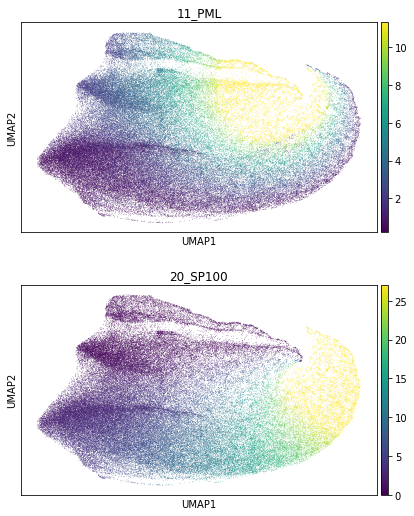

In [103]:
sc.pl.umap(adata, color=['11_PML', '20_SP100'], vmax='p95', vmin='p05', ncols=1)

/tmp/ipykernel_14357/3432923843.py:5: RuntimeWarning: invalid value encountered in true_divide
  mean_TR = vals / counts


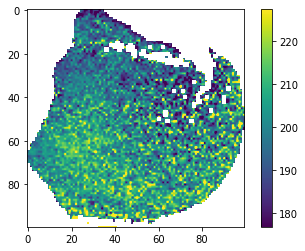

In [101]:
# calculate mean TR at binned locations in UMAP
counts, binx, biny = np.histogram2d(x=adata.obsm['X_umap'][:,1], y=adata.obsm['X_umap'][:,0], normed=False, bins=100)
vals, binx, biny = np.histogram2d(x=adata.obsm['X_umap'][:,1], y=adata.obsm['X_umap'][:,0], normed=False, bins=100, weights=adata.obs['TR_norm'])

mean_TR = vals / counts
q01 = np.quantile(mean_TR[~np.isnan(mean_TR)], 0.05)
q09 = np.quantile(mean_TR[~np.isnan(mean_TR)], 0.95)

plt.imshow(mean_TR[::-1], vmin=q01, vmax=q09)
plt.colorbar()